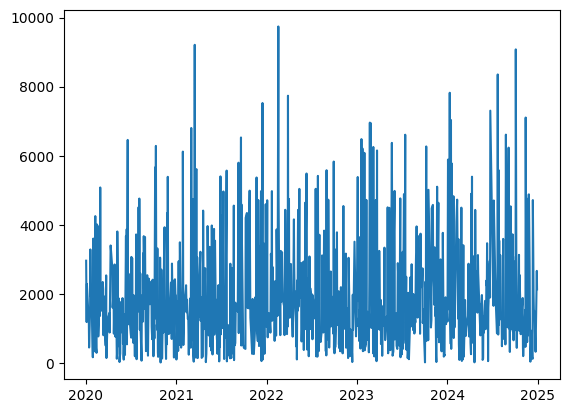

In [1]:
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
from preprocess import load_and_clean

df = load_and_clean("../data/transactions.csv")
plt.plot(df["date"], df["daily_expense"])
plt.show()

Is there seasonality? Yes, there is a consistent sharp increase and this pattern repeats at the same time every year.

Spikes? Yes, there are frequent and significant 

Long-term trend? Slightly upward(Bullish). The overall volume of transactions is increasing overtime, even if the day-to-day data is very jumpy.

Train size: (820, 2)
Test size: (205, 2)


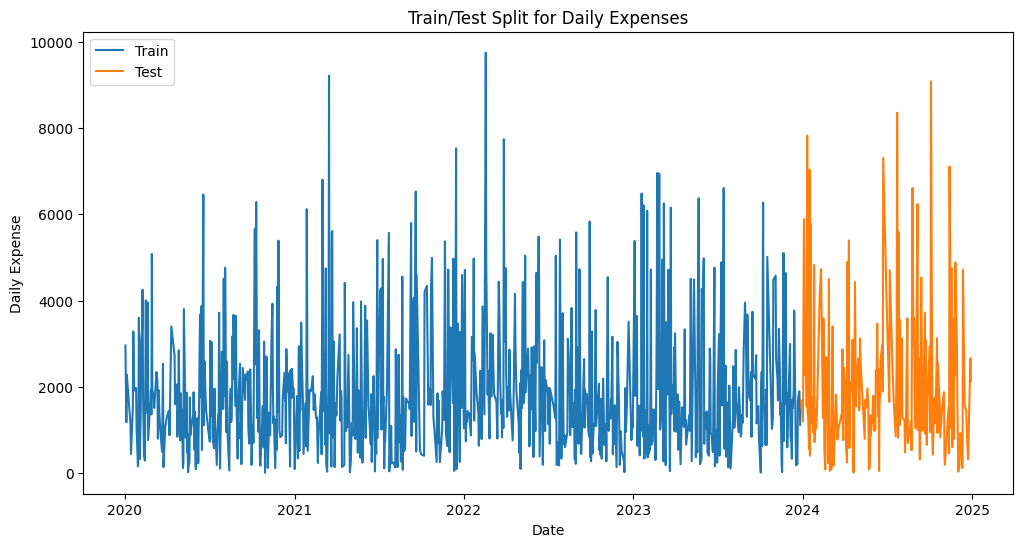

In [2]:
#Train/Test split (80% train, 20% test)
split_index = int(0.8 * len(df))

train = df.iloc[:split_index]
test = df.iloc[split_index:]

print("Train size:", train.shape)
print("Test size:", test.shape)

#Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train["date"], train["daily_expense"], label="Train")
plt.plot(test["date"], test["daily_expense"], label="Test")
plt.legend()
plt.title("Train/Test Split for Daily Expenses")
plt.xlabel("Date")
plt.ylabel("Daily Expense")
plt.show()



In [3]:
import sys
sys.path.append("../src")

from train import train_arima

#Train ARIMA model
train_series = train.set_index("date")["daily_expense"]
model_fit = train_arima(train_series, order=(1,1,1))

#summary of the model
print(model_fit.summary())


/Users/sosee/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sosee/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sosee/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          daily_expense   No. Observations:                  820
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7146.332
Date:                Wed, 14 Jan 2026   AIC                          14298.663
Time:                        11:19:21   BIC                          14312.788
Sample:                             0   HQIC                         14304.083
                                - 820                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0129      0.036     -0.356      0.722      -0.084       0.058
ma.L1         -0.9999      0.167     -5.971      0.000      -1.328      -0.672
sigma2      2.205e+06   3.34e+05      6.604      0.0

In [6]:
from forecast import forecast_model

#forecast same length as test set
forecast = forecast_model(model_fit, len(test))

#Quick check
print("Forecast (first 5 days):")
print(forecast.head())
print("Actual (first 5 days):")
print(test["daily_expense"].head())

Forecast (first 5 days):
820    1879.996428
821    1870.282977
822    1870.407896
823    1870.406289
824    1870.406310
Name: predicted_mean, dtype: float64
Actual (first 5 days):
820    1687.43
821    1201.00
822    5888.00
823    2266.00
824    2316.41
Name: daily_expense, dtype: float64


/Users/sosee/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sosee/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test["daily_expense"], forecast)
rmse = np.sqrt(mean_squared_error(test["daily_expense"], forecast))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 1184.273932013149
RMSE: 1693.3332327201076


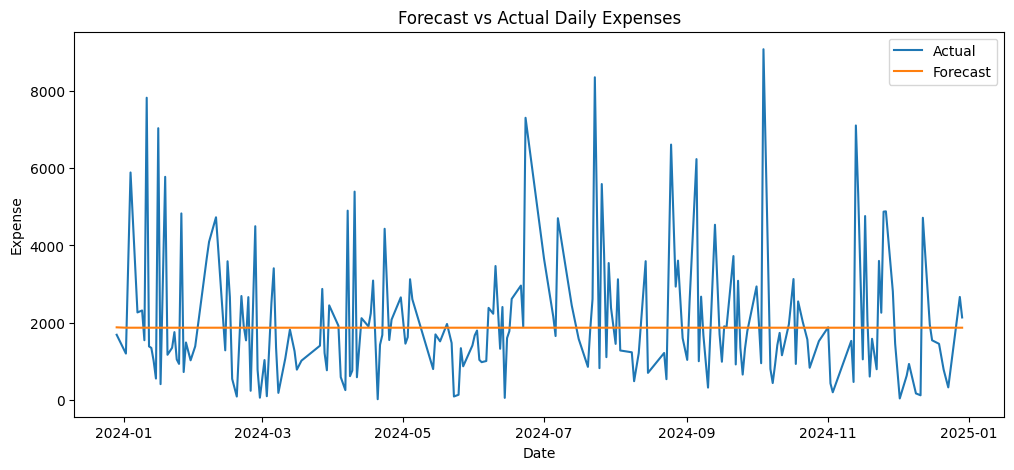

In [7]:
plt.figure(figsize=(12,5))
plt.plot(test["date"], test["daily_expense"], label="Actual")
plt.plot(test["date"], forecast, label="Forecast")
plt.legend()
plt.title("Forecast vs Actual Daily Expenses")
plt.xlabel("Date")
plt.ylabel("Expense")
plt.show()

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train SARIMA on train set
# seasonal_order = (P, D, Q, s) -> here s=7 for weekly seasonality
sarima_model = SARIMAX(
    train.set_index("date")["daily_expense"],
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit()

print(sarima_fit.summary())

/Users/sosee/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sosee/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78037D+00    |proj g|=  1.49113D-01

At iterate    5    f=  8.72230D+00    |proj g|=  5.81165D-01

At iterate   10    f=  8.70760D+00    |proj g|=  1.36488D-02

At iterate   15    f=  8.70738D+00    |proj g|=  6.51898D-04

At iterate   20    f=  8.70737D+00    |proj g|=  3.72587D-03

At iterate   25    f=  8.70705D+00    |proj g|=  3.45272D-02

At iterate   30    f=  8.69227D+00    |proj g|=  1.36819D-01

At iterate   35    f=  8.58067D+00    |proj g|=  1.30291D-01

At iterate   40    f=  8.56566D+00    |proj g|=  7.83822D-03

At iterate   45    f=  8.56565D+00    |proj g|=  8.00425D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [9]:
# Forecast same length as test set
sarima_forecast = sarima_fit.forecast(steps=len(test))

# Compare first 5 predictions
print("Forecast vs Actual (first 5 rows):")
print(sarima_forecast.head())
print(test["daily_expense"].head())

Forecast vs Actual (first 5 rows):
820    1859.058256
821    1843.899501
822    1977.078606
823    1889.116999
824    1856.786004
Name: predicted_mean, dtype: float64
820    1687.43
821    1201.00
822    5888.00
823    2266.00
824    2316.41
Name: daily_expense, dtype: float64


/Users/sosee/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sosee/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test["daily_expense"], sarima_forecast)
rmse = np.sqrt(mean_squared_error(test["daily_expense"], sarima_forecast))

print("SARIMA MAE:", mae)
print("SARIMA RMSE:", rmse)

SARIMA MAE: 1188.4998748225075
SARIMA RMSE: 1699.2573345436463


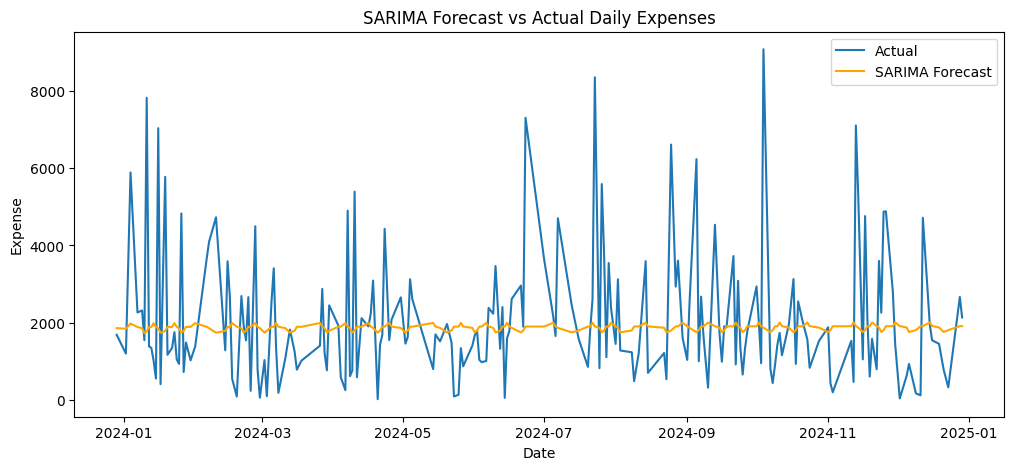

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test["date"], test["daily_expense"], label="Actual")
plt.plot(test["date"], sarima_forecast, label="SARIMA Forecast", color="orange")
plt.legend()
plt.title("SARIMA Forecast vs Actual Daily Expenses")
plt.xlabel("Date")
plt.ylabel("Expense")
plt.show()